In [45]:
# load custom image processing library
%run 'image_processor.py'

ip=ImageProcessor('../images/sample_images', '../images/sample_work')

Processing ../images/sample_images/0acbebb8d463b4b9ca88cf38431aac69
 > 203 slices read


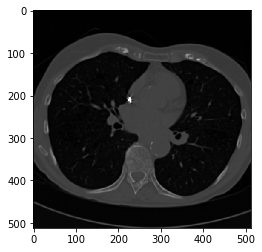

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# patient_id = '0c37613214faddf8701ca41e6d43f56e'
patient_id = '0acbebb8d463b4b9ca88cf38431aac69' # problematic?

#patient_id = '00cba091fa4ad62cc3200a657aeb957e'
# slices = ip.load_patient('ca-0015ceb851d7251b8f399e39779d1e7d')

slices = ip.load_patient(patient_id)
mid_slice = round(len(slices)/2)

plt.imshow(slices[mid_slice].pixel_array, cmap=plt.cm.gray)
plt.show()

In [47]:
%%time
pxls = ip.get_pixels_hu(slices)
# resample to 1x1x1
pix_resampled, spacing = ip.resample(pxls, slices, [1, 1, 1])
ip.save_images_as_npy(pix_resampled, spacing, patient_id)

print("Shape before resampling\t", pxls.shape)
print("Shape after resampling\t", pix_resampled.shape)


Shape before resampling	 (203, 512, 512)
Shape after resampling	 (365, 279, 279)
CPU times: user 20.4 s, sys: 220 ms, total: 20.6 s
Wall time: 20.9 s


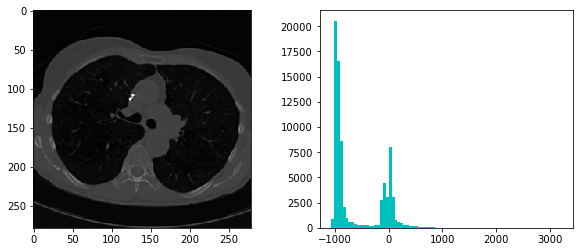

In [60]:
mid_slice = round(len(pix_resampled)/2)
mid_slice=pix_resampled[230]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].imshow(mid_slice, cmap=plt.cm.gray)
axes[1].hist(mid_slice.flatten(), bins=80, color='c')
plt.show()


In [72]:
# lungs segmentation

img = round(len(pix_resampled)/2)
#img = pix_resampled[230] mask fails
img = pix_resampled[289] # NODULE


mask, segment = ip.create_lungs_mask(img)

# Plot results
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

ax1.imshow(img, cmap='gray', interpolation='nearest')
ax1.set_adjustable('box-forced')
ax1.set_title('Original')

ax2.imshow(mask, cmap='gray', interpolation='nearest')
ax2.set_adjustable('box-forced')
ax2.set_title('Mask')

ax3.imshow(segment, cmap='gray', interpolation='nearest')
ax3.set_adjustable('box-forced')
ax3.set_title('Result')

fig.tight_layout()
plt.show()

In [65]:
%%time
# create all masks
masks, segmented = ip.create_lungs_masks(pix_resampled, patient_id)
print(pix_resampled.shape)
print(masks.shape)

(365, 279, 279)
(365, 279, 279)
CPU times: user 43.3 s, sys: 370 ms, total: 43.7 s
Wall time: 44.2 s


In [66]:
img = round(len(segmented)/2)
img = segmented[289]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img, cmap=plt.cm.gray)
axes[1].hist(img[img!=-1000].flatten(), bins='auto', color='c')

plt.show()


In [67]:
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [68]:
%%time
plot_3d(segmented, -500)

CPU times: user 1min 30s, sys: 1.49 s, total: 1min 31s
Wall time: 1min 32s


In [52]:
img = round(len(segmented)/2)
img = segmented[img]

msk = np.where(img > -800, 1.0, 0.0)
seg = img * msk

print(msk.shape)
print(seg.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img, cmap=plt.cm.gray)
axes[1].imshow(seg, cmap=plt.cm.gray)
plt.show()

(279, 279)
(279, 279)


In [53]:
from skimage import data, color
from skimage.transform import hough_circle
from skimage.feature import canny
from skimage.draw import circle_perimeter
from skimage.util import img_as_ubyte


# Load picture and detect edges
image = round(len(segmented)/2)
image = segmented[image]
#edges = canny(image, sigma=3, low_threshold=10, high_threshold=50)
edges = canny(image, sigma=3)


# Detect two radii
hough_radii = np.arange(3, 30, 1)
res = hough_circle(edges, hough_radii)
ridx, r, c = np.unravel_index(np.argmax(res), res.shape)
r, c, ridx


# Select the most prominent 5 circles
#accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
#                                           total_num_peaks=3)

# Draw them
#fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
#image = color.gray2rgb(image)
#for center_y, center_x, radius in zip(cy, cx, radii):
#    circy, circx = circle_perimeter(center_y, center_x, radius)
#    image[circy, circx] = (220, 20, 20)

#ax.imshow(image, cmap=plt.cm.gray)
#plt.show()

(0, 0, 0)

In [55]:
i = round(len(segmented)/3)
img = segmented[i]
i = round(i*2)
img1 = segmented[i]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(img, cmap=plt.cm.gray)
axes[1].imshow(img1, cmap=plt.cm.gray)
plt.show()

In [21]:
# Parenchyma structures extraction - calc thresholds

# from all segmented slices, get diagonal histogram to determine thresholds
all_diagonals = [p.diagonal() for p in segmented]
master_diagonal = np.concatenate(all_diagonals).ravel()

# calc thresholds
hist = np.histogram(master_diagonal.flatten(), bins='auto')
# get indices of two peaks
indices=hist[0].argsort()[-1:]
p1 = hist[1][indices[0]]
L=(p1)/2.
print('Histogram of diagonals peaks at {0} so threshold is HU = {1}'.format(p1,L))
plt.hist(master_diagonal.flatten(), bins='auto')
plt.show()



Histogram of diagonals peaks at -1002.5033407572383 so threshold is HU = -501.25167037861917
